This notebook supports the equations that govern contaminant uptake and impacts on the biology within the Salish Sea Atlantis model. It shows the 1-day output of simulations after injecting PAH components of oil into the water column, to observe biological uptake, as well as non-lethal and lethal impacts relative to a control simulation with no contaminants injected.

Half lives

| PAH Concentration	|	Naphthalene |	Phenanthrene | Pyrene |	Benzo(a)pyrene |
|-------------------|---------------|-----------------|--------|----------|
| Half life (secs)	|	259200 |	3628800	| 20476800	| 19353600 |
| Half life (days)	|	3	| 42 |	237 |	224 |

In [1]:
import os
import xarray as xr
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import ssam_groups as groups

In [33]:
control_name = '7a_v6699_1000mg_single_highres_control'
control_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Tests/"+ control_name + "/outputSalishSea.nc"
control = xr.open_dataset(str(control_file), decode_cf=True)

In [34]:
time = np.ma.filled(control.variables['t'], np.nan)

In [35]:
scenario_root = Path('/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Tests/')
scenario_paths = sorted([p for p in scenario_root.glob('7a_v6699_1000kg_single_highres/outputSalishSea.nc')])
scenario_datasets = [xr.open_dataset(scen,decode_cf=True) for scen in scenario_paths]

In [36]:
for scenario in scenario_datasets:
    time = np.ma.filled(scenario.variables['t'], np.nan)

In [37]:
duration_ns = time - time[0]
duration = duration_ns.astype('timedelta64[D]')
duration[1]

numpy.timedelta64(0,'D')

In [38]:
scenario_labels = []
for path in scenario_paths:
    scenario_labels.append(path.parent.stem)

In [43]:
def plot_group(group, scenario_datasets, scenario_paths):
    for scenario, path in zip(scenario_datasets, scenario_paths):
        fig, ax = plt.subplots(figsize = (14,3))
        nm = path.parent.stem
        for variable in group:
            contam_tbl = np.ma.filled(scenario.variables[variable], np.nan)
            volume_tbl = np.ma.filled(scenario.volume, np.nan)
            contam_mass_tbl = contam_tbl * volume_tbl
            contam_mass_tb = contam_mass_tbl.sum(axis=2)
            contam_mass_t = contam_mass_tb.sum(axis=1)
            ax.plot(time, contam_mass_t/1e6)
        ax.legend(group,  loc='best')
        ax.set_ylabel('mass (kg)')
        ax.set_xlabel('Time')
        ax.set_title(nm)
        

In [53]:
def compare_scenario_pah(species, pah, boxes=groups.salish_sea):
    fig, ax = plt.subplots(figsize = (14,3))
    names = []
    for scenario, path in zip(scenario_datasets, scenario_paths):
        names.append(path.parent.stem)
        contam_tbl = np.ma.filled(scenario.variables[species+'_' + pah][:,boxes,:], np.nan)
        volume_tbl = np.ma.filled(scenario.variables['volume'][:,boxes,:], np.nan)
        contam_mass_tbl = contam_tbl * volume_tbl
        contam_mass_tb = contam_mass_tbl.sum(axis=2)
        contam_mass_t = contam_mass_tb.sum(axis=1)
        ax.plot(duration, contam_mass_t/1e6)
    ax.legend(names)
    ax.set_ylabel(species + ' PAH (kg)')
    ax.set_title(pah, fontsize = 12);

In [49]:
def print_max_pah_mass(species, scenario_datasets, scenario_paths):
    for scenario, path in zip(scenario_datasets, scenario_paths):
        for pah in groups.pahs:
            contam_tbl = np.ma.filled(scenario.variables[species +'_'+ pah], np.nan)
            volume_tbl = np.ma.filled(scenario.variables['volume'], np.nan)
            contam_mass_tbl = contam_tbl * volume_tbl
            contam_mass_tb = contam_mass_tbl.sum(axis=2)
            contam_mass_t = contam_mass_tb.sum(axis=1)
            max_contam_mass = contam_mass_t.max()/1e6
            print(path.parent.stem, species, pah, max_contam_mass)

### Water Column - without resets

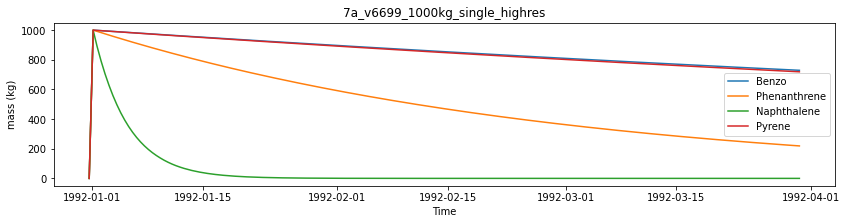

In [44]:
plot_group(groups.pahs, scenario_datasets, scenario_paths)

### Biology

Uptake rates for contaminants in phytoplankton
- PL_Naphthalene_uptake_rate    = 3.0e-3
- PL_Phenanthrene_uptake_rate   = 2.0e-4
- PL_Pyrene_uptake_rate         = 1.4e-4
- PL_Benzo_uptake_rate          = 8.0e-5

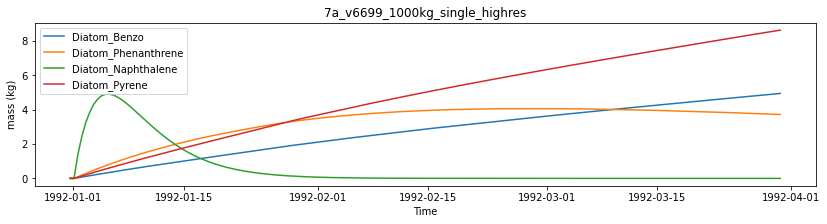

In [45]:
new_group = {}
for pah in groups.pahs:
    new_group['Diatom_'+pah]= 'Diatom_' +pah
plot_group(new_group, scenario_datasets, scenario_paths)

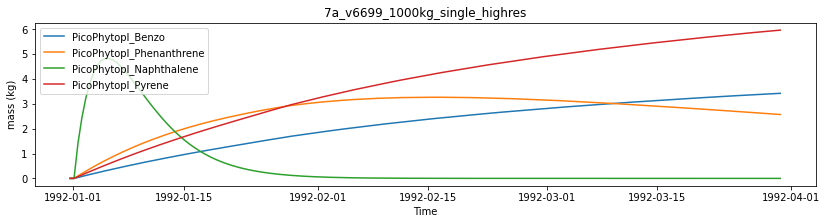

In [46]:
new_group = {}
for pah in groups.pahs:
    new_group['PicoPhytopl_'+pah]= 'PicoPhytopl_' +pah
plot_group(new_group, scenario_datasets, scenario_paths)

In [50]:
print_max_pah_mass('Ref_Det', scenario_datasets, scenario_paths)

7a_v6699_1000kg_single_highres Ref_Det Benzo 1012.4371007854805
7a_v6699_1000kg_single_highres Ref_Det Phenanthrene 176.5597572282494
7a_v6699_1000kg_single_highres Ref_Det Naphthalene 0.006586969199569008
7a_v6699_1000kg_single_highres Ref_Det Pyrene 1769.2669217270573


In [51]:
max_Ref_Det_Phe_percent = (176.55976/1000)*100
max_Ref_Det_Phe_percent

17.655976000000003

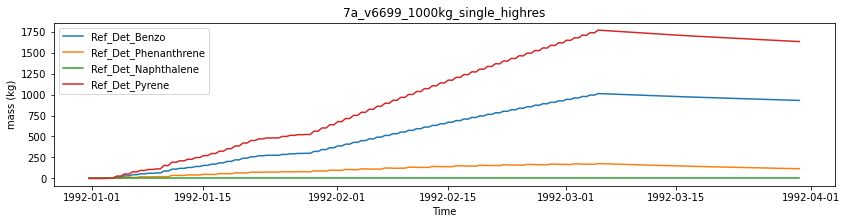

In [52]:
new_group = {}
for pah in groups.pahs:
    new_group['Ref_Det_'+pah]= 'Ref_Det_' +pah
plot_group(new_group, scenario_datasets, scenario_paths)

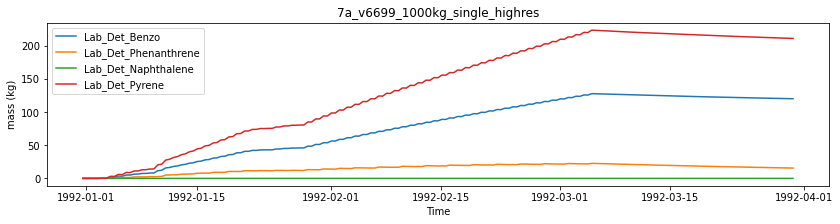

In [54]:
new_group = {}
for pah in groups.pahs:
    new_group['Lab_Det_'+pah]= 'Lab_Det_' +pah
plot_group(new_group, scenario_datasets, scenario_paths)

### vertebrate contaminants

Hake (FHK) - example vertebrate with faster spawn/recruitment time
- Time of year Hake spawn (FHK_Time_Spawn): Day 70
- Length of larval period for Hake: (FHK_Recruit_Time) = 20 days
- FHK_Naphthalene_uptake_rate 1.0e-09

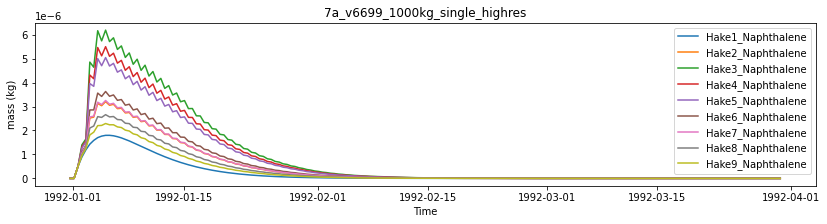

In [55]:
new_group = {}
for cohort in range (1, groups.cohorts['Hake']):
    new_group['Hake'+str(cohort)+'_Naphthalene']= 'Hake'+str(cohort)+'_Naphthalene'
plot_group(new_group, scenario_datasets, scenario_paths)

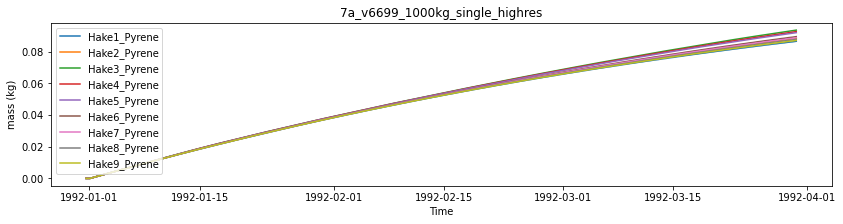

In [56]:
new_group = {}
for cohort in range (1, groups.cohorts['Hake']):
    new_group['Hake'+str(cohort)+'_Pyrene']= 'Hake'+str(cohort)+'_Pyrene'
plot_group(new_group, scenario_datasets, scenario_paths)

No difference in concentrations over time for the different cohorts of Hake

### Initial conditions - numbers, biomass, % cover

Harbour Seals (HSK) - example vertebrate with longer spawn/gestation time
- Time of year Harbour Seals (HSL_Time_Spawn): Day 290
- Length of gestation period for Harbour seals (HSL_Recruit_Time) = 330 days
- HSL_Naphthalene_uptake_rate 1.0e-09

In [81]:
orr_numbers = 0
for cohort in range (1, groups.cohorts['Orcas_resident']):
    new_group['Orcas_resident'+str(cohort)]= 'Orcas_resident'+str(cohort)+'_Nums'
    orr_tbl = np.ma.filled(scenario.variables['Orcas_resident'+str(cohort)+'_Nums'], np.nan)
    orr_tb = orr_tbl.sum(axis=2)
    orr_t = orr_tb.sum(axis=1)
    orr_numbers = orr_numbers + orr_t
print('Number of resident orcas at '+str(time[0])+': '+str(orr_numbers[0]))

Number of resident orcas at 1991-12-31T14:00:00.000000000: 356.39000000000004


In [17]:
herring = 0
herring_tbl = np.ma.filled(scenario.variables['Pacific_herring1_Nums'], np.nan)
herring_tb = herring_tbl.sum(axis=2)
herring_t = herring_tb.sum(axis=1)
herring = herring + herring_t
print('Numbers of Pacific Herring at '+str(time[0])+': '+str(herring[0]))
#fig, ax = plt.subplots(figsize = (14,3))
#ax.plot(time, herring_t)

Numbers of Pacific Herring at 1991-12-31T14:00:00.000000000: 122399999.0


In [18]:
herring = 0
herring_tbl = np.ma.filled(scenario.variables['Pacific_herring2_Nums'], np.nan)
herring_tb = herring_tbl.sum(axis=2)
herring_t = herring_tb.sum(axis=1)
herring = herring + herring_t
print('Numbers of Pacific Herring age 2 at '+str(time[0])+': '+str(herring[0]))

Numbers of Pacific Herring age 2 at 1991-12-31T14:00:00.000000000: 74664002.0


In [19]:
sockeye = 0
sockeye_tbl = np.ma.filled(scenario.variables['Sockeye_salmon1_Nums'], np.nan)
sockeye_tb = sockeye_tbl.sum(axis=2)
sockeye_t = sockeye_tb.sum(axis=1)
sockeye = sockeye + sockeye_t
print('Numbers of Sockeye_salmon at '+str(time[0])+': '+str(sockeye[0]))

Numbers of Sockeye_salmon at 1991-12-31T14:00:00.000000000: 5979999.0


In [21]:
ratfish = 0
ratfish_tbl = np.ma.filled(scenario.variables['Ratfish1_Nums'], np.nan)
ratfish_tb = ratfish_tbl.sum(axis=2)
ratfish_t = ratfish_tb.sum(axis=1)
ratfish = ratfish + ratfish_t
print('Numbers of Ratfish at '+str(time[0])+': '+str(ratfish[0]))

Numbers of Ratfish at 1991-12-31T14:00:00.000000000: 2736001.0


In [23]:
sponges = 0
sponges_tb = np.ma.filled(scenario.variables['Sponges_N'], np.nan)
sponges_t = sponges_tb.sum(axis=1)
sponges = (sponges + sponges_t) #*14.0067
print('Biomass of Sponges at '+str(time[0])+': '+str(sponges[0]))

Biomass of Sponges at 1991-12-31T14:00:00.000000000: 283.95


In [24]:
sponges = 0
sponges_tb = np.ma.filled(scenario.variables['Sponges_Cover'], np.nan)
sponges_t = sponges_tb.sum(axis=1)
sponges = (sponges + sponges_t) #*14.0067
print('% Cover of Sponges at '+str(time[0])+': '+str(sponges[0]))

% Cover of Sponges at 1991-12-31T14:00:00.000000000: 0.38243749999999993


In [26]:
macroalgae = 0
macroalgae_tb = np.ma.filled(scenario.variables['Macroalgae_N'], np.nan)
macroalgae_t = macroalgae_tb.sum(axis=1)
macroalgae = (macroalgae + macroalgae_t) #*14.0067
print('Biomass of Macroalgae at '+str(time[0])+': '+str(macroalgae[0]))

Biomass of Macroalgae at 1991-12-31T14:00:00.000000000: 1970.6799999999998


In [29]:
macroalgae = 0
macroalgae_tb = np.ma.filled(scenario.variables['Macroalgae_Cover'], np.nan)
macroalgae_t = macroalgae_tb.sum(axis=1)
macroalgae = (macroalgae + macroalgae_t) #*14.0067
print('% Cover of Macroalgae at '+str(time[0])+': '+str(macroalgae[0]))

% Cover of Macroalgae at 1991-12-31T14:00:00.000000000: 1.6422333316


In [28]:
seagrass = 0
seagrass_tb = np.ma.filled(scenario.variables['Seagrass_N'], np.nan)
seagrass_t = seagrass_tb.sum(axis=1)
seagrass = (seagrass + seagrass_t) #*14.0067
print('Biomass of Seagrass at '+str(time[0])+': '+str(seagrass[0]))

Biomass of Seagrass at 1991-12-31T14:00:00.000000000: 1484.01


In [30]:
seagrass = 0
seagrass_tb = np.ma.filled(scenario.variables['Seagrass_Cover'], np.nan)
seagrass_t = seagrass_tb.sum(axis=1)
seagrass = (seagrass + seagrass_t) #*14.0067
print('% Cover of Seagrass at '+str(time[0])+': '+str(seagrass[0]))

% Cover of Seagrass at 1991-12-31T14:00:00.000000000: 4.9467
